In [1]:
# jVMC
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jVMC
import jVMC.nets as nets
import jVMC.operator as op
import jVMC.sampler
from jVMC.vqs import NQS

# jax
import jax
import jax.numpy as jnp
import jax.random as random

import numpy as np

# optimisation
import optax

# plotting
import matplotlib.pyplot as plt


2025-06-23 10:53:04.484482: W external/xla/xla/service/platform_util.cc:199] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 84974239744


# Minimising the infidelity for a trial model and a given target model

## First create the reference ground state
We define a transverse field ising hamiltonian.

In [2]:
# create the transvere field Ising model Hamiltonian
sz = np.array([[1,0],[0,-1]])
sx = np.array([[0,1],[1,0]])

def tm(pm,i,N):
    if i == 0:
        re_ma = np.kron(pm,np.identity(2**(N-1)))
    else: re_ma = np.kron(np.identity(2**i),np.kron(pm,np.identity(2**(N-i-1))))
    return re_ma

#now we change H
def create_H(g,J,N):
  H_1 = tm(sx,0,N)
  for i in range(1,N): H_1 += tm(sx,i,N)

  H_0 = tm(sz,0,N).dot(tm(sz,1,N))+tm(sz,N-1,N).dot(tm(sz,0,N))
  for i in range(1,N-1): H_0 += tm(sz,i,N).dot(tm(sz,i+1,N))
  return -0.5*(g*H_1-J*H_0)

-3.192347281801834


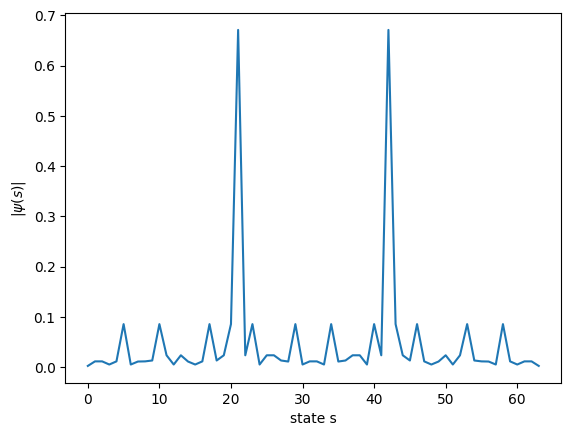

In [3]:
#############
# define the exact system
#############
 # sysetm parameters
L = 6
Ns = 2**L
# plot the ground state
#v,w = np.linalg.eigh(create_H(.01,1.,N))
J = 1.
g = 0.5
v,w = np.linalg.eigh(create_H(g,J,L))
gs = abs(w[:,0])
# getting the position of the Neel states
sigma = np.arange(2**L)[abs(gs)>0.1] # get peaked states
# plot
figure = plt.figure(dpi=100)
plt.plot(abs(gs))
plt.xlabel("state s")
plt.ylabel("$|\\psi(s)|$")
print(v[0])

In [4]:
# set the wave function as target
chi_model = nets.Target(L=L,d=2)
# initialize the target model
chi = NQS(chi_model)
print("Net init: ",chi(jnp.array(jnp.ones((1, 1, L)))))
# setting the parameters
chi.set_parameters(jnp.array(gs))

Net init:  [[1.11022302e-15+0.j]]


## Infidelity

The infidelity for two pure states is defined as
$$
\mathcal{I} = 1 - \sum_s \Psi(s)\frac{\chi(s)}{\psi(s)}\times\sum_{s'} \Chi(s')\frac{\psi(s')}{\chi(s')} = 1 - \mathbb{E}_\Psi\frac{\chi(s)}{\psi(s)}\times\mathbb{E}_\Chi\frac{\psi(s')}{\chi(s')}
$$
where we have introduced the short-hand for the Born distribution for the target and trial wave function
$$
\Psi(s) = \frac{\psi(s)}{\sum_s|\psi(s)|^2} \qquad \Chi(s') = \frac{\chi(s')}{\sum_{s'}|\chi(s')|^2}  
$$
With the local infidelity 
$$
F^\psi_{\rm loc}(s) = \frac{\chi(s)}{\psi(s)}\times\sum_{s'} \qquad F^\chi_{\rm loc}(s') = \frac{\psi(s')}{\chi(s')} 
$$
the infidelity can be expressed as 
$$
\mathcal{I} = 1 - \mathbb{E}_\Psi F^\psi_{\rm loc}(s)\times\mathbb{E}_\Chi F^\chi_{\rm loc}(s')
$$
The derivative is
$$
2\mathbb{E}_\Psi\big[ \Re~ O_k(s)F^\psi_{\rm loc}(s)\big] \, F^\chi-2\mathbb{E}_\Psi\big[ \Re~ O_k(\sigma)\big] \, F^\psi \, F^\chi
$$

In [5]:
rbm = nets.CpxRBM(numHidden=2**4, bias=True) # get variational model
psi = NQS(rbm) # initialize variational model
psi(jnp.ones((1, 1, L)))

Array([[0.00086387+0.01467127j]], dtype=complex128)

In [6]:
n_iter = 300 # number of optimisation iterations
s_infidelity_acc = np.zeros(n_iter)

In [7]:
learning_rate=1e-3
# create the optimizer
optimizer = optax.adabelief(learning_rate=learning_rate)
# init optimizer
state = optimizer.init(psi.get_parameters())# test the compactified class

In [8]:
# set up sampler for the target
chiSampler = jVMC.sampler.MCSampler(chi, (L,), random.PRNGKey(np.random.randint(1000000)), updateProposer=jVMC.sampler.propose_spin_flip_Z2,
                                    numChains=20, sweepSteps=L,
                                    numSamples=1000, thermalizationSweeps=25)
# set up the infidelity
myInf = op.Infidelity(chiSampler=chiSampler,chi=chi,getCV=True)

In [21]:
# Set up sampler for psi
psiSampler = jVMC.sampler.MCSampler(psi, (L,), random.PRNGKey(np.random.randint(1000)), updateProposer=jVMC.sampler.propose_spin_flip_Z2,
                                numChains=20, sweepSteps=L,
                                numSamples=100, thermalizationSweeps=25)

for i in range(n_iter):
    if i%10 == 0: print("Iteration %i"%(i))
    ######## get infidelity ########
    chi_Floc, Exp_chi_Floc = myInf.get_FP_loc(psi)
    psi_s, psi_logPsi, psi_p = psiSampler.sample()
    _, _ = myInf.get_s_primes(psi_s)
    chi_logPsi = chi(psi_s)
    psi_Floc = myInf.get_O_loc_unbatched(psi_logPsi,chi_logPsi)
    psi_Floc = myInf.get_O_loc(psi_s,psi,psi_logPsi,psi_p)
    print(psi_Floc[0].shape,psi_p.shape)
    I_mean = jVMC.mpi_wrapper.global_mean(psi_Floc,psi_p)
    s_infidelity_acc[i] = I_mean.real
    print("Infidelity: %.6f"%(I_mean.real))

    # get the gradients
    F_grad, psi_grad = myInf.get_gradient(psi,psi_p)

    # get the psi parameters
    psi_params = psi.get_parameters()

    # update optimiser state
    updates, state = optimizer.update(F_grad.reshape(psi_params.shape), state, psi_params)  # Update para?meters
    params = optax.apply_updates(psi_params, updates)
    # set paramters again
    psi.set_parameters(params)

Iteration 0
(100,) (1, 100)
Infidelity: 0.560910
(100,) (1, 100)
Infidelity: 0.788124
(100,) (1, 100)
Infidelity: 0.789156
(100,) (1, 100)
Infidelity: 2.166095
(100,) (1, 100)
Infidelity: 0.790510
(100,) (1, 100)
Infidelity: 1.224677
(100,) (1, 100)
Infidelity: 0.615245
(100,) (1, 100)
Infidelity: 0.602080
(100,) (1, 100)
Infidelity: 1.026113
(100,) (1, 100)
Infidelity: 2.056587
Iteration 10
(100,) (1, 100)
Infidelity: 1.009920
(100,) (1, 100)
Infidelity: 1.323190
(100,) (1, 100)
Infidelity: 0.949279
(100,) (1, 100)
Infidelity: 0.577123
(100,) (1, 100)
Infidelity: 0.592669
(100,) (1, 100)
Infidelity: 0.858731
(100,) (1, 100)
Infidelity: 0.694811
(100,) (1, 100)
Infidelity: 0.933572
(100,) (1, 100)
Infidelity: 1.009356
(100,) (1, 100)
Infidelity: 0.575626
Iteration 20
(100,) (1, 100)
Infidelity: 0.712238
(100,) (1, 100)
Infidelity: 0.547697
(100,) (1, 100)
Infidelity: 0.594241
(100,) (1, 100)
Infidelity: 0.518192
(100,) (1, 100)
Infidelity: 0.939540
(100,) (1, 100)
Infidelity: 1.311259


Text(0, 0.5, '$\\mathcal{I}$')

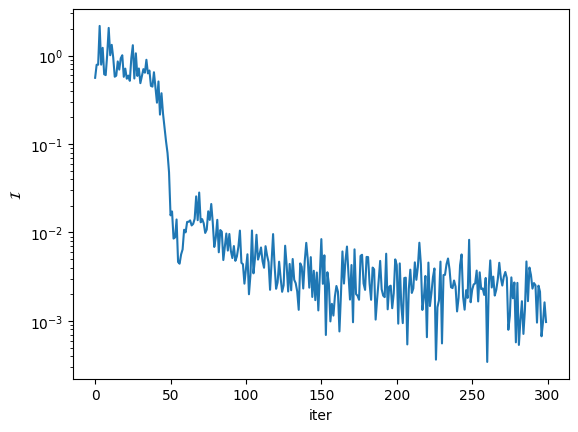

In [22]:
plt.plot(jnp.arange(n_iter),abs(s_infidelity_acc))
plt.yscale("log")
plt.xlabel("iter")
plt.ylabel("$\\mathcal{I}$")